# Creación del modelo 

A continuación, se avanza con la creación de una Red Neuronal Recurrente (RNN) diseñada para estimar la cantidad de insumos requeridos en la toma de muestras nasales para el diagnóstico de COVID-19. Para este propósito, se emplea la biblioteca Keras para la implementación de la red.

## Parte 1: Carga de librerías

Se procede a importar las bibliotecas que serán utilizadas a lo largo del desarrollo de este proyecto.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score, mean_squared_error

## Parte 2: Construcción del modelo

Se procede con la carga de los datos con la ayuda de la libreria pandas.

In [3]:
df = pd.read_excel("base_datos_procesada/datos_procesados.xlsx")
df.head()

,AnoMesTransferencia,Cantidad_transferida
0,2021-06-30,1669
1,2021-07-31,2796
2,2021-08-31,1427
3,2021-09-30,1974
4,2021-10-31,1833


La serie se representa gráficamente.

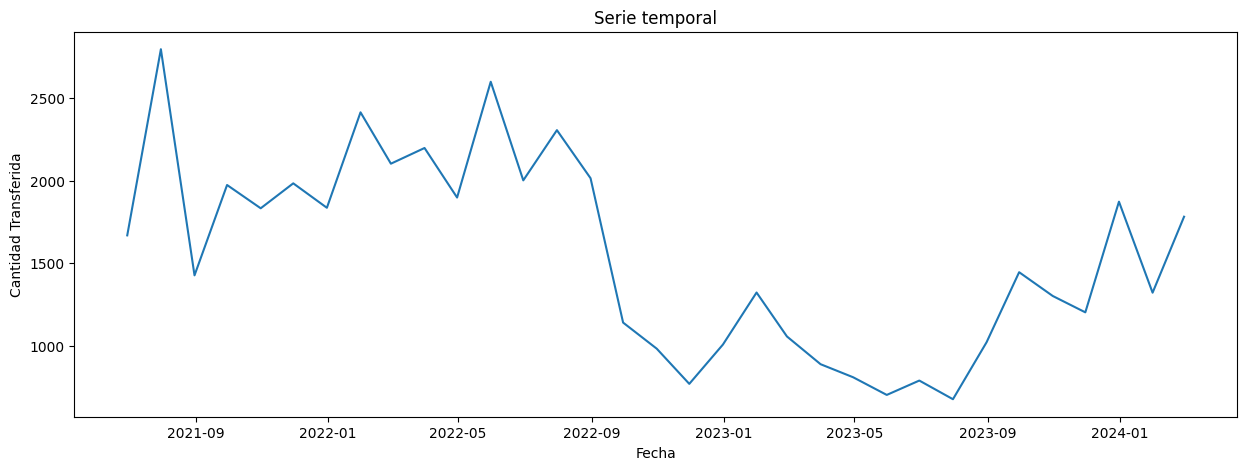

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(df['AnoMesTransferencia'], df['Cantidad_transferida'])
plt.xlabel("Fecha")
plt.ylabel("Cantidad Transferida")
plt.title('Serie temporal')
plt.show()

El conjunto de datos se divide en conjunto de entrenamiento y conjunto de prueba.

In [5]:
# Crear un filtro para seleccionar los datos a partir del 2023-06-30
filtro_desde_2023_06_30 = df['AnoMesTransferencia'] >= '2023-06-30'
# Crear DataFrame de prueba con datos a partir del 2023-06-30
df_test = df[filtro_desde_2023_06_30]
# Crear DataFrame de entrenamiento con datos anteriores a 2023-06-30
df_train = df[~filtro_desde_2023_06_30]

# Reiniciar índices en el DataFrame de entrenamiento
df_train.reset_index(drop=True, inplace=True)
# Reiniciar índices en el DataFrame de prueba
df_test.reset_index(drop=True, inplace=True)


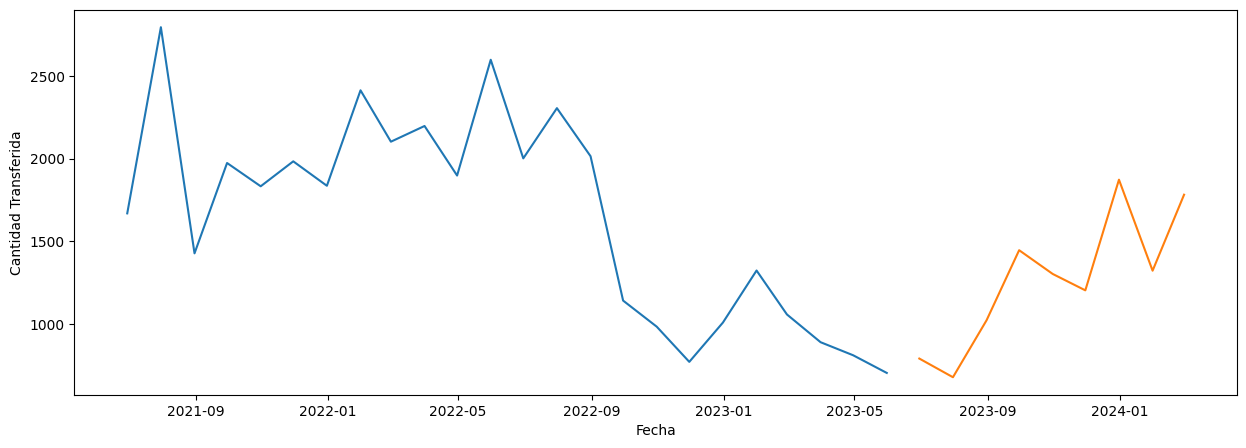

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(df_train['AnoMesTransferencia'], df_train['Cantidad_transferida'])
plt.plot(df_test['AnoMesTransferencia'], df_test['Cantidad_transferida'])
plt.xlabel("Fecha")
plt.ylabel("Cantidad Transferida")
plt.show()

Se realiza el proceso de escalamiento

In [7]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(df_train.iloc[:, 1:2].values)

Se prepara los datos para el entrenamiento de la RNN

In [8]:
X_train = []
y_train = []
timesteps = 2

for i in range(timesteps, (training_set_scaled.shape[0]-1)):
    X_train.append(training_set_scaled[i-timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

#Redimensión de los datos
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Se establece la arquitectura del modelo de red neuronal recurrente.

In [9]:
#Inicialización del modelo
regressor = Sequential()

#Añadir la primera capa de LSTM y la regularización Dropout
regressor.add(LSTM(
    units=50,
    return_sequences=True,
    input_shape = (X_train.shape[1], 1)
))
regressor.add(Dropout(0.2))

#Añadir la segunda capa de LSTM y la regularización Dropout
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

#Añadir la tercer capa de LSTM y la regularización Dropout
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

#Añadir la cuarta capa de LSTM y la regularización Dropout
regressor.add(LSTM(units=50, return_sequences=False))
regressor.add(Dropout(0.2))

#Añadir la capa de salida
regressor.add(Dense(units=1))

In [10]:
regressor.compile(
    optimizer='adam',
    loss    = 'mean_squared_error'
)

Entrenamiento del modelo

In [11]:
regressor.fit(
    x=X_train,
    y=y_train,
    epochs=300,
    batch_size=2
)

Epoch 1/300
11/11 [==============================] - 21s 11ms/step - loss: 0.2495
Epoch 2/300
11/11 [==============================] - 0s 16ms/step - loss: 0.1781
Epoch 3/300
11/11 [==============================] - 0s 11ms/step - loss: 0.0921
Epoch 4/300
11/11 [==============================] - 0s 15ms/step - loss: 0.0714
Epoch 5/300
11/11 [==============================] - 0s 9ms/step - loss: 0.0574
Epoch 6/300
11/11 [==============================] - 0s 18ms/step - loss: 0.0495
Epoch 7/300
11/11 [==============================] - 0s 10ms/step - loss: 0.0511
Epoch 8/300
11/11 [==============================] - 0s 20ms/step - loss: 0.0540
Epoch 9/300
11/11 [==============================] - 0s 22ms/step - loss: 0.0444
Epoch 10/300
11/11 [==============================] - 0s 13ms/step - loss: 0.0395
Epoch 11/300
11/11 [==============================] - 0s 12ms/step - loss: 0.0445
Epoch 12/300
11/11 [==============================] - 0s 12ms/step - loss: 0.0438
Epoch 13/300
11/11 [=====

Se comprueba el funcionamiento del modelo con los datos de test

In [12]:
y_test = df_test.iloc[:, 1:2].values

inicio = len(df) - len(df_test) - timesteps
inputs = df['Cantidad_transferida'][inicio:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(timesteps, (len(df_test) + timesteps)):
    X_test.append(inputs[(i-timesteps):i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

y_pred = regressor.predict(X_test)

y_pred = sc.inverse_transform(y_pred)

1/1 [==============================] - 3s 3s/step


A continuación, se presenta visualmente la respuesta del modelo con los datos de test

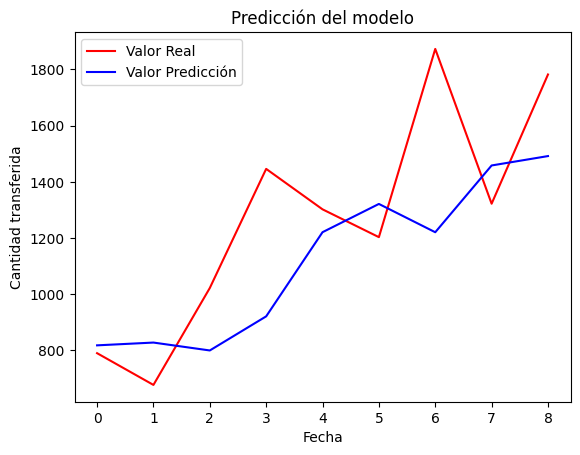

In [13]:
plt.plot(y_test, color='red', label='Valor Real')
plt.plot(y_pred, color='blue', label='Valor Predicción')
plt.title('Predicción del modelo')
plt.xlabel("Fecha")
plt.ylabel("Cantidad transferida")
plt.legend()
plt.show()

Cálculo del RMSE (Raíz Cuadrada del Error Cuadrático Medio).

In [14]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {}".format(rmse))

RMSE: 315.8338708580405


Cálculo del \[ R^2 \]

In [15]:
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.3138915739162833
